# 08. PyTorch Experiment Tracking Exercises

Welcome to the 08. PyTorch Paper Replicating exercises.

Your objective is to write code to satisify each of the exercises below.

Some starter code has been provided to make sure you have all the resources you need.

> **Note:** There may be more than one solution to each of the exercises.

## Resources

1. These exercises/solutions are based on [section 08. PyTorch Paper Replicating](https://www.learnpytorch.io/08_pytorch_paper_replicating/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/tjpW_BY8y3g) (but try the exercises yourself first!).
3. See [all solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

> **Note:** The first section of this notebook is dedicated to getting various helper functions and datasets used for the exercises. The exercises start at the heading "Exercise 1: ...".

### Get various imports and helper functions

The code in the following cells prepares imports and data for the exercises below. They are taken from [08. PyTorch Paper Replicating](https://www.learnpytorch.io/08_pytorch_paper_replicating/).

In [ ]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")


[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/nightly/cu113
  Using cached torch-2.2.0-cp310-cp310-manylinux1_x86_64.whl (755.5 MB)
  Using cached torchvision-0.17.0-cp310-cp310-manylinux1_x86_64.whl (6.9 MB)
  Using cached torchaudio-2.2.0-cp310-cp310-manylinux1_x86_64.whl (3.3 MB)
  Using cached typing_extensions-4.9.0-py3-none-any.whl (32 kB)
  ERROR: HTTP error 403 while getting https://download.pytorch.org/whl/nightly/nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (from https://download.pytorch.org/whl/nightly/cu113/nvidia-cuda-nvrtc-cu12/)
ERROR: Could not install requirement nvidia-cuda-nvrtc-cu12==12.1.105 from https://download.pytorch.org/whl/nightly/nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (from torch) because of HTTP error 403 Client Error: Forbidden for url: https://download.pytorch.org/whl/nightly/nvidia_cuda_nvrtc_cu12-12.1.

In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Get data

Want to download the data we've been using in PyTorch Paper Replicating: https://www.learnpytorch.io/08_pytorch_paper_replicating/#1-get-data

In [ ]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [ ]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

### Preprocess data

Turn images into tensors using same code as PyTorch Paper Replicating section 2.1 and 2.2: https://www.learnpytorch.io/08_pytorch_paper_replicating/#21-prepare-transforms-for-images

In [ ]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [ ]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7bc104253c70>,
 ['pizza', 'steak', 'sushi'])

In [ ]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

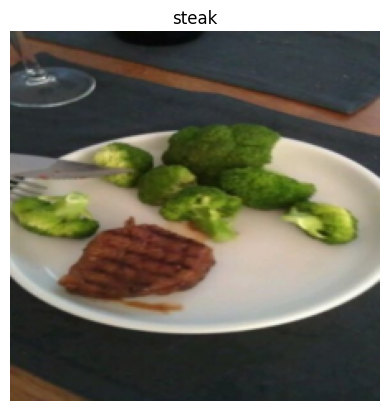

In [ ]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

## 1. Replicate the ViT architecture we created with in-built [PyTorch transformer layers](https://pytorch.org/docs/stable/nn.html#transformer-layers).

* You'll want to look into replacing our `TransformerEncoderBlock()` class with [`torch.nn.TransformerEncoderLayer()`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html#torch.nn.TransformerEncoderLayer) (these contain the same layers as our custom blocks).
* You can stack `torch.nn.TransformerEncoderLayer()`'s on top of each other with [`torch.nn.TransformerEncoder()`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html#torch.nn.TransformerEncoder).

#### Equation 1 - put everything together
Now let's put everything together to go from $\mathbf{x}$ -> $\mathbf{x_p}$ -> $\mathbf{z_0}$

$$z_0 = \left[ x_{\text{class}} ; x^1_pE; x^2_pE; \ldots ; x^N_pE \right] + E_{\text{pos}}, where$$ $ \quad E \in \mathbb{R}^{(P^2C) \times D}, \quad E_{\text{pos}} \in \mathbb{R}^{(N+1) \times D}, \quad \mathbf{x} \in \mathbb{R}^{H \times W \times C}, \quad \mathbf{x_p} \in \mathbb{R}^{N \times P^2C}, \quad \mathbf{x_\text{class}} \in \mathbb{R}^{1 \times D} \text{ and } N=H*W/P^2, D=768$

In [ ]:
class PatchEmbed(nn.Module):
  def __init__(self, patch_size:int, in_shape:int, embed_dim:int):
    super().__init__()
    self.cnn_layer = nn.Conv2d(in_channels=in_shape, out_channels=embed_dim, kernel_size=patch_size, stride=patch_size, padding=0)
    self.flatten_layer = nn.Flatten(start_dim=2, end_dim=3)
  def forward(self, x):
    return self.flatten_layer(self.cnn_layer(x)).permute(0, 2, 1)

class ViT(nn.Module):
  def __init__(self,
               image_size=(224,224),
               patch_size=16,
               n_classes=3,
               embed_dim=768,
               activation='gelu',
               dropout=0.1,
               mlp_size=3072,
               nhead=12,
               num_layers=12
               ):
    super().__init__()
    self.embedding_num = int(image_size[0]*image_size[1]/patch_size**2)
    self.embedding_class = nn.Parameter(torch.rand([1, 1, embed_dim]), requires_grad=True)
    self.embedding_pos = nn.Parameter(torch.rand([1, self.embedding_num+1, embed_dim]), requires_grad=True)
    self.embedding_patch = PatchEmbed(patch_size=patch_size, in_shape=n_classes, embed_dim=embed_dim)
    self.transformer = nn.TransformerEncoder(
                            encoder_layer=nn.TransformerEncoderLayer(
                                                d_model=embed_dim,
                                                nhead=nhead,
                                                dim_feedforward=mlp_size,
                                                dropout=dropout,
                                                activation=activation,
                                                batch_first=True,
                                                norm_first=True),
                            num_layers=num_layers)
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embed_dim),
        nn.Linear(in_features=embed_dim, out_features=n_classes)
    )
  def forward(self, x):
    batch_size = x.shape[0]
    embedding_class = self.embedding_class.expand(batch_size, -1, -1)

    x = self.embedding_patch(x)
    x = torch.concat([embedding_class, x], dim=1) + self.embedding_pos
    x = self.transformer(x)
    x = self.classifier(x[:,0])
    return x

# try
vit = ViT()
summary(model=vit,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                     [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbed (embedding_patch)                [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (cnn_layer)                     [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten_layer)                [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─TransformerEncoder (transformer)            [32, 197, 768]       [32, 197, 768]       --                   True
│    └─ModuleList (layers)                    --                   --                   --                   True
│    │    └─TransformerEncoderLayer (0)       [32, 197, 768]       [32, 197, 768]       7,087,872            True
│    │    └─TransformerEncoderLayer (1)       [32, 197, 768]       [32, 197, 768]    

## 2. Turn the custom ViT architecture we created into a Python script, for example, `vit.py`.

* You should be able to import an entire ViT model using something like`from vit import ViT`.
* We covered the art of turning code cells into Python scrips in [05. PyTorch Going Modular](https://www.learnpytorch.io/05_pytorch_going_modular/).


In [ ]:
%%writefile vit.py
"""
Contains ViT class
"""

import torch.nn as nn
import torch

IMG_SIZE = 224

class PatchEmbed(nn.Module):
  def __init__(self, patch_size:int, in_shape:int, embed_dim:int):
    super().__init__()
    self.cnn_layer = nn.Conv2d(in_channels=in_shape, out_channels=embed_dim, kernel_size=patch_size, stride=patch_size, padding=0)
    self.flatten_layer = nn.Flatten(start_dim=2, end_dim=3)
  def forward(self, x):
    return self.flatten_layer(self.cnn_layer(x)).permute(0, 2, 1)

class ViT(nn.Module):
  def __init__(self,
               image_size=(IMG_SIZE,IMG_SIZE),
               patch_size=16,
               n_classes=3,
               embed_dim=768,
               activation='gelu',
               dropout=0.1,
               mlp_size=3072,
               nhead=12,
               num_layers=12
               ):
    super().__init__()
    self.embedding_num = int(image_size[0]*image_size[1]/patch_size**2)
    self.embedding_class = nn.Parameter(torch.rand([1, 1, embed_dim]), requires_grad=True)
    self.embedding_pos = nn.Parameter(torch.rand([1, self.embedding_num+1, embed_dim]), requires_grad=True)
    self.embedding_patch = PatchEmbed(patch_size=patch_size, in_shape=n_classes, embed_dim=embed_dim)
    self.transformer = nn.TransformerEncoder(
                            encoder_layer=nn.TransformerEncoderLayer(
                                                d_model=embed_dim,
                                                nhead=nhead,
                                                dim_feedforward=mlp_size,
                                                dropout=dropout,
                                                activation=activation,
                                                batch_first=True,
                                                norm_first=True),
                            num_layers=num_layers)
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embed_dim),
        nn.Linear(in_features=embed_dim, out_features=n_classes)
    )
  def forward(self, x):
    batch_size = x.shape[0]
    embedding_class = self.embedding_class.expand(batch_size, -1, -1)

    x = self.embedding_patch(x)
    x = torch.concat([embedding_class, x], dim=1) + self.embedding_pos
    x = self.transformer(x)
    x = self.classifier(x[:,0])
    return x

Overwriting vit.py


In [ ]:
from vit import ViT
# try
vit = ViT()
summary(model=vit,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                     [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbed (embedding_patch)                [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (cnn_layer)                     [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten_layer)                [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─TransformerEncoder (transformer)            [32, 197, 768]       [32, 197, 768]       --                   True
│    └─ModuleList (layers)                    --                   --                   --                   True
│    │    └─TransformerEncoderLayer (0)       [32, 197, 768]       [32, 197, 768]       7,087,872            True
│    │    └─TransformerEncoderLayer (1)       [32, 197, 768]       [32, 197, 768]    

## 3. Train a pretrained ViT feature extractor model (like the one we made in [08. PyTorch Paper Replicating section 10](https://www.learnpytorch.io/08_pytorch_paper_replicating/#10-bring-in-pretrained-vit-from-torchvisionmodels-on-same-dataset)) on 20% of the pizza, steak and sushi data like the dataset we used in [07. PyTorch Experiment Tracking section 7.3](https://www.learnpytorch.io/07_pytorch_experiment_tracking/#73-download-different-datasets)
* See how it performs compared to the EffNetB2 model we compared it to in [08. PyTorch Paper Replicating section 10.6](https://www.learnpytorch.io/08_pytorch_paper_replicating/#106-save-feature-extractor-vit-model-and-check-file-size).

In [ ]:
# Download 10 percent and 20 percent training data (if necessary)
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")
# Setup train/test directory paths
train_dir_20 = data_20_percent_path / "train"

# Check the directories
print('data paths:')
print(train_dir_20)

# Create data loaders
train_dataloader_20, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir_20,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

print('data loaders')
print(train_dataloader_20, test_dataloader, class_names)

[INFO] data/pizza_steak_sushi_20_percent directory exists, skipping download.
data paths:
data/pizza_steak_sushi_20_percent/train
data loaders
<torch.utils.data.dataloader.DataLoader object at 0x7bc1042532b0> <torch.utils.data.dataloader.DataLoader object at 0x7bc104252b90> ['pizza', 'steak', 'sushi']


In [ ]:
# set the number of epochs
NUMBER_EPOCHS = 10

# create optimizer and loss
optimizer = torch.optim.Adam(params=vit.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

# set seeds
set_seeds()

# train
results_vit = engine.train(model=vit,
             train_dataloader=train_dataloader_20, # 20% train data
             test_dataloader=test_dataloader, # 10% test data
             optimizer=optimizer,
             loss_fn=loss_fn,
             epochs=NUMBER_EPOCHS,
             device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1281 | train_acc: 0.3396 | test_loss: 1.2527 | test_acc: 0.1979
Epoch: 2 | train_loss: 1.1192 | train_acc: 0.3396 | test_loss: 1.0103 | test_acc: 0.5417
Epoch: 3 | train_loss: 1.1074 | train_acc: 0.3979 | test_loss: 1.0061 | test_acc: 0.5417
Epoch: 4 | train_loss: 1.0207 | train_acc: 0.4708 | test_loss: 1.1822 | test_acc: 0.3125
Epoch: 5 | train_loss: 1.0559 | train_acc: 0.4479 | test_loss: 1.0417 | test_acc: 0.5019
Epoch: 6 | train_loss: 1.0730 | train_acc: 0.4000 | test_loss: 0.9643 | test_acc: 0.4830
Epoch: 7 | train_loss: 1.0402 | train_acc: 0.4500 | test_loss: 1.2788 | test_acc: 0.2604
Epoch: 8 | train_loss: 1.0764 | train_acc: 0.4437 | test_loss: 1.1940 | test_acc: 0.2500
Epoch: 9 | train_loss: 1.0373 | train_acc: 0.4521 | test_loss: 1.1158 | test_acc: 0.3617
Epoch: 10 | train_loss: 1.0615 | train_acc: 0.4417 | test_loss: 1.0816 | test_acc: 0.3920


## 4. Try repeating the steps from excercise 3 but this time use the "`ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1`" pretrained weights from [`torchvision.models.vit_b_16()`](https://pytorch.org/vision/stable/models/generated/torchvision.models.vit_b_16.html#torchvision.models.vit_b_16).
* Note: ViT pretrained with SWAG weights has a minimum input image size of (384, 384), though this is accessible in the weights `.transforms()` method.

In [ ]:
# pre trained transformer
vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
vit_transforms = vit_weights.transforms()

# Create data loaders
train_dataloader_20_pre_train, test_dataloader_pre_train, class_names = data_setup.create_dataloaders(
    train_dir=train_dir_20,
    test_dir=test_dir,
    transform=vit_transforms,
    batch_size=BATCH_SIZE
)

# get the pre trained vit model
vit_pre_trained = torchvision.models.vit_b_16(weights=vit_weights, progress=False)

# freeze all the parameters
for param in vit_pre_trained.parameters():
  param.requires_grad = False
# except for the classifier layer
vit_pre_trained.heads = nn.Linear(in_features=768, out_features=3, device=device)

# get the summary
summary(model=vit_pre_trained,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [ ]:
# create optimizer and loss
optimizer = torch.optim.Adam(params=vit_pre_trained.parameters(),lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

# set seeds
set_seeds()

# train
results_vit_pre_train = engine.train(
    model=vit_pre_trained,
    train_dataloader=train_dataloader_20_pre_train, # 20% train data
    test_dataloader=test_dataloader_pre_train, # 10% test data
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=NUMBER_EPOCHS,
    device=device
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6767 | train_acc: 0.8083 | test_loss: 0.3290 | test_acc: 0.8873
Epoch: 2 | train_loss: 0.2463 | train_acc: 0.9208 | test_loss: 0.2622 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.1749 | train_acc: 0.9604 | test_loss: 0.2291 | test_acc: 0.8977
Epoch: 4 | train_loss: 0.1258 | train_acc: 0.9667 | test_loss: 0.2081 | test_acc: 0.9280
Epoch: 5 | train_loss: 0.1111 | train_acc: 0.9667 | test_loss: 0.2069 | test_acc: 0.9280
Epoch: 6 | train_loss: 0.1286 | train_acc: 0.9396 | test_loss: 0.1980 | test_acc: 0.9176
Epoch: 7 | train_loss: 0.0900 | train_acc: 0.9771 | test_loss: 0.1975 | test_acc: 0.9176
Epoch: 8 | train_loss: 0.0926 | train_acc: 0.9833 | test_loss: 0.2130 | test_acc: 0.9280
Epoch: 9 | train_loss: 0.0929 | train_acc: 0.9854 | test_loss: 0.2314 | test_acc: 0.9280
Epoch: 10 | train_loss: 0.0662 | train_acc: 0.9875 | test_loss: 0.2100 | test_acc: 0.9280


### Results comparison

Custom ViT loss:


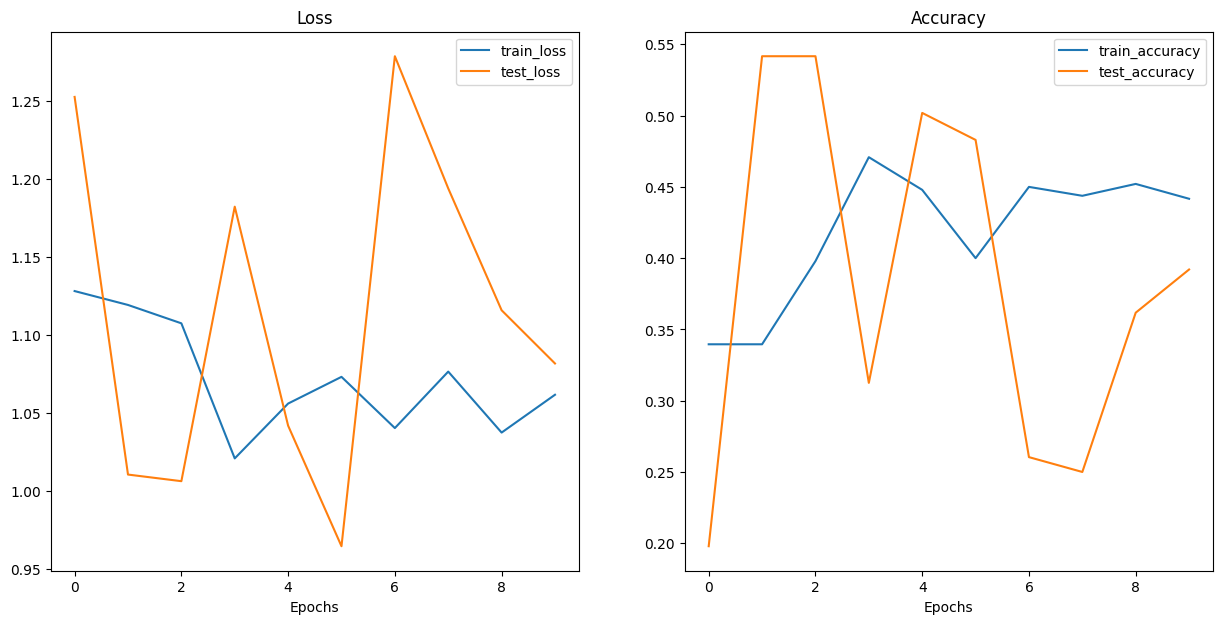

In [ ]:
from helper_functions import plot_loss_curves

print('Custom ViT loss:')
plot_loss_curves(results_vit)

Pre-trained ViT loss:


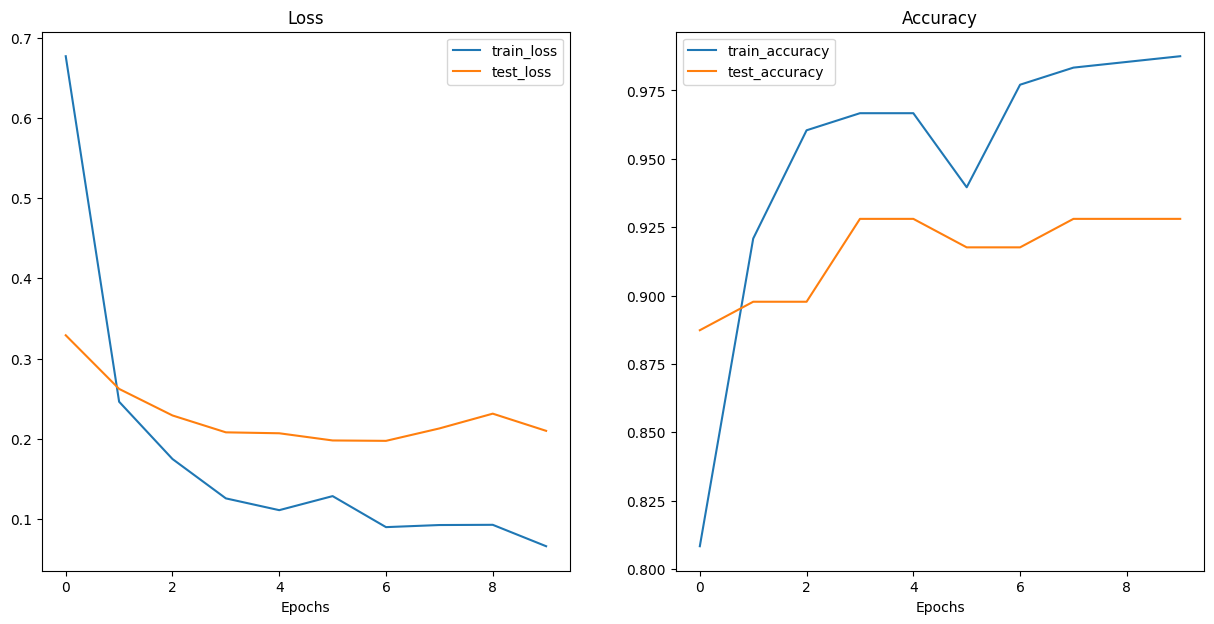

In [ ]:
print('Pre-trained ViT loss:')
plot_loss_curves(results_vit_pre_train)

# 5. Our custom ViT model architecture closely mimics that of the ViT paper, however, our training recipe misses a few things.
* Research some of the following topics from Table 3 in the ViT paper that we miss and write a sentence about each and how it might help with training:
    * **ImageNet-21k pretraining**
    * **Learning rate warmup**
    * **Learning rate decay**
    * **Gradient clipping**

- **ImageNet-21k pretraining** - ImageNet dataset with 21000 classes (extension of the ImageNet dataset we have been using so far). A model, that is trained on this large dataset, can the underlying patterns better, possibly, achieving higher accuracy, given that sufficient computational resources are available.
- **Learning rate warmup** - Increase of learning rate over training, avoiding early overfitting.
- **Learning rate decay** - Slowly lower the learning rate to improve the optimization.
- **Gradient clipping** - Reduce the gradient by some amount to avoid exploding gradients.